In [101]:
import kaleido as kd
import nbformat as nb
import numpy as np
import pandas as pd
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as pyo
from plotly.graph_objs import *
from tqdm.notebook import trange, tqdm
%matplotlib inline

In [102]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import re



In [103]:
print("When will you be traveling?")
travel_date = input("Input travel date as YYYY-MM-DD")
print("Travel Date:", travel_date)
print("Is this day flexible?")
flex_date = input("Enter how many days before your tentative leave day you would like your search to start or enter 0 if your travel date is set")
print("Days flexible:", flex_date)
print("How long would you like to travel?")
days_long = input("Enter trip length")
print("Trip length:", days_long)
print("Where will you be flying from?")
origin = input("Input three letter airport code of where you are flying from.")
print("Origin:", origin)
print("Where would you like to fly too? Enter as many destinations as you would like!")

destination = [input("Input three letter airport code of where you want to fly to.").upper()]

def destination_adder():
    while destination:
        new_destination = input("Enter another destination, enter a destination again to remove it from the list or Q to quit").upper()
        if new_destination.upper() == "Q":
            print("All done!")
            break
        elif new_destination == "":
            print(destination[-1], "popped from the list")
            new_destination = destination.pop()
            print(destination)
        elif new_destination in destination:
            print(new_destination, "popped from the list")
            destination.remove(new_destination)
            print(destination)
        elif new_destination not in destination:
            print("1 instance of", new_destination, "added to the list")
            destination.append(new_destination)
            print(destination)
        else:
            print("List of destinations", destination)
            destination_adder(new_destination)
            print(destination)
    print("All Destination inputed!")
destination_adder()

scope = 2

When will you be traveling?
Travel Date: 2023-05-23
Is this day flexible?
Days flexible: 0
How long would you like to travel?
Trip length: 7
Where will you be flying from?
Origin: ATL
Where would you like to fly too? Enter as many destinations as you would like!
1 instance of MIA added to the list
['LAX', 'MIA']
1 instance of LAS added to the list
['LAX', 'MIA', 'LAS']
All done!
All Destination inputed!


In [104]:

start = (datetime.datetime.strptime(travel_date,"%Y-%m-%d")) - timedelta(days=int(flex_date))
t = trange(scope)
for n in t:
    start_date = str(start + timedelta(days=n)).split()[0]
    t.set_description('Checking Dates: ' + start_date)
    end_date = str((start + timedelta(days=n)) + timedelta(days=int(days_long))).split()[0]

    for location in destination:
        url = "https://www.kayak.com/flights/"+origin+"-"+location+"/"+str(start_date)+"/"+str(end_date)+"?sort=bestflight_a&fs=stops=0"
	
        s = Service("C:/Users/tmanj/OneDrive/Documents/GitHub/Whereto/chromedriver.exe")
        options = webdriver.ChromeOptions() 
        options.add_experimental_option('excludeSwitches', ['enable-logging']) 
        driver = webdriver.Chrome(service=s, options=options)
        driver.get(url)
        sleep(3)
        soup = BeautifulSoup(driver.page_source, 'html.parser')

        deptimes = soup.find_all('span', attrs={'class': 'vmXl vmXl-mod-variant-large'})
        arrtimes = soup.find_all('span', attrs={'class': 'arrival-time base-time'})
        meridies = soup.find_all('span', attrs={'class': 'time-meridiem meridiem'})
                    
        deptime = []
        for div in deptimes:
            deptime.append(div.getText()[:-1])    
                        
        arrtime = []
        for div in arrtimes:
            arrtime.append(div.getText()[:-1])   
                
        meridiem = []
        for div in meridies:
            meridiem.append(div.getText())  
                        
        deptime = np.asarray(deptime)
        deptime = deptime.reshape(int(len(deptime)/2), 2)
                    
        arrtime = np.asarray(arrtime)
        arrtime = arrtime.reshape(int(len(arrtime)/2), 2)      
                    
        meridiem = np.asarray(meridiem)
        meridiem = meridiem.reshape(int(len(meridiem)/4), 4)       

        regex = re.compile('Common-Booking-MultiBookProvider (.*)multi-row Theme-featured-large(.*)')
        price_list = soup.find_all('div', attrs={'class': regex})
                    
        price = []
    for div in price_list:
        price.append(int(div.getText().split('\n')[3][1:-1]))
	 

        
        
        

  0%|          | 0/2 [00:00<?, ?it/s]

In [105]:
df = pd.DataFrame({"Origin" : origin,
"Destination" : destination,
"Startdate" : start_date,
"Enddate" : end_date,
"Price": price,
"Currency": "USD",
"Deptime_o": [m+str(n) for m,n in zip(deptime[:,0],meridiem[:,0])],
"Arrtime_d": [m+str(n) for m,n in zip(arrtime[:,0],meridiem[:,1])],
"Deptime_d": [m+str(n) for m,n in zip(deptime[:,1],meridiem[:,2])],
"Arrtime_o": [m+str(n) for m,n in zip(arrtime[:,1],meridiem[:,3])]
})

print(df)

ValueError: All arrays must be of the same length

In [106]:
cheapest = df.groupby(['Origin','Destination'])['Price'].min().reset_index()
cheapest.sort_values(by=['Origin','Price'], inplace=True)
cheapest['Price'] = cheapest['Price'].replace('$', '')
cheapest['Price'] = cheapest['Price'].replace(',', '')
cheapest['Price'] = cheapest['Price'].apply(pd.to_numeric)
cheapest['Origin'] = pd.to_datetime(cheapest['Origin'])

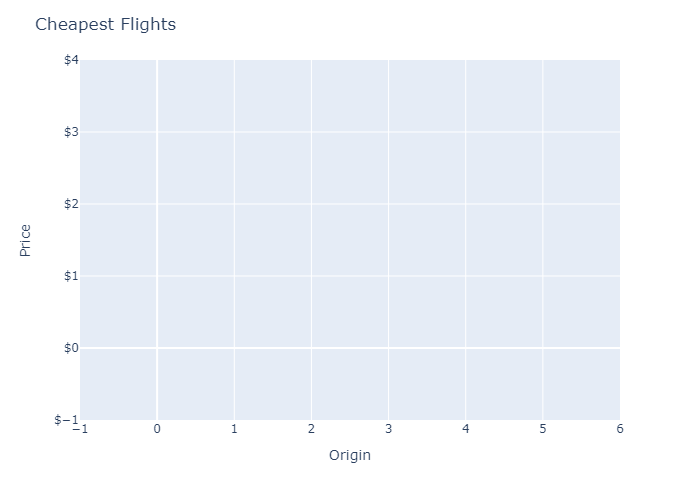

In [107]:
fig = px.line(cheapest, x='Origin', y='Price', color='Destination')
fig.update_yaxes(tickprefix="$", tickformat=",")
fig.update_xaxes(tickformat="%d %b (%a)")
fig.update_layout(title_text="Cheapest Flights")
fig.show('png')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

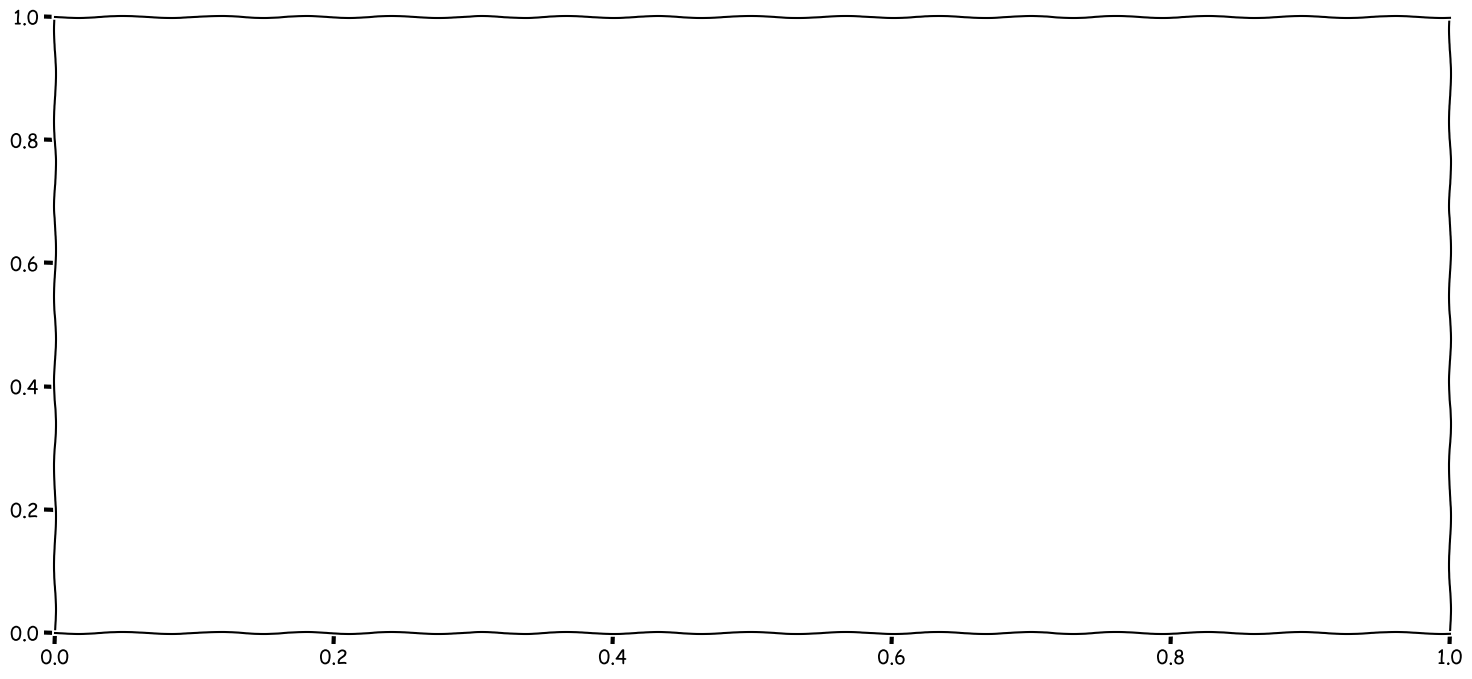

In [72]:
plt.xkcd()
fig, ax = plt.subplots(figsize=(18,8))

for dest in cheapest['Destination'].unique():
    temp = cheapest[cheapest['Destination']==dest]
    ax.plot(temp['Departure'], temp['Price'], label=dest)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('£{x:,.0f}'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b (%a)'))
    #plt.grid(color='b', linestyle='-', linewidth=.5)
    plt.legend()